In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as C
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model,Model
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import regularizers, constraints, initializers
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D
# import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2.6.0


In [2]:
train_path=('/LAB/Brain Tumor/Brain Tumor MRI/train')
test_path=('/LAB/Brain Tumor/Brain Tumor MRI/test')
val_path=('/LAB/Brain Tumor/Brain Tumor MRI/val')
batch_size = 32
img_height = 512
img_width = 512
no_of_clases = 4
clsses_name = ['glioma','meninginoma','notumor','pituitary tumor']
input_shape = (img_height,img_width,1)

datagen = ImageDataGenerator(rescale = 1./255,featurewise_center=True,horizontal_flip=False,vertical_flip = False,validation_split = 0.1,featurewise_std_normalization = True)

train_generator = datagen.flow_from_directory(train_path,target_size=(img_height,img_width),batch_size = batch_size, shuffle =True,class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(val_path,target_size=(img_height,img_width),batch_size = batch_size, shuffle =True,class_mode = 'categorical')

print('train classes')
print(train_generator.class_indices)
print('train labels')
print(train_generator.labels)
print('validation clases')
print(validation_generator.class_indices)
print('validation labels')
print(validation_generator.labels)

Found 5617 images belonging to 4 classes.
Found 701 images belonging to 4 classes.
train classes
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
train labels
[0 0 0 ... 3 3 3]
validation clases
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
validation labels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [3]:
print(len(train_generator))

176


In [4]:
pretrained_model = tf.keras.applications.ResNet101V2(
                    input_shape=(512, 512, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg',
                    )

pretrained_model.trainable = False

2024-03-09 12:54:19.031859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21915 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-03-09 12:54:19.032723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 420 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


171327488/171317808 [==============================] - 71s 0us/step


In [5]:
inputs = pretrained_model.input
outputs = tf.keras.layers.Dense(4, activation='softmax')(pretrained_model.output)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 258, 258, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizers,loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
#callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_generator,validation_data=validation_generator,epochs=100)

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2024-03-09 12:55:33.122980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2024-03-09 12:55:39.450342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


  1/176 [..............................] - ETA: 27:45 - loss: 1.4509 - accuracy: 0.2188

2024-03-09 12:55:42.664859: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176/176 [==============================] - 70s 345ms/step - loss: 0.5476 - accuracy: 0.8061 - val_loss: 0.3409 - val_accuracy: 0.8830
Epoch 2/100
176/176 [==============================] - 59s 334ms/step - loss: 0.3018 - accuracy: 0.8950 - val_loss: 0.2740 - val_accuracy: 0.8944
Epoch 3/100
176/176 [==============================] - 59s 335ms/step - loss: 0.2451 - accuracy: 0.9156 - val_loss: 0.2420 - val_accuracy: 0.9087
Epoch 4/100
176/176 [==============================] - 60s 338ms/step - loss: 0.2080 - accuracy: 0.9297 - val_loss: 0.2294 - val_accuracy: 0.9144
Epoch 5/100
176/176 [==============================] - 59s 333ms/step - loss: 0.1893 - accuracy: 0.9386 - val_loss: 0.2213 - val_accuracy: 0.9116
Epoch 6/100
176/176 [==============================] - 59s 336ms/step - loss: 0.1678 - accuracy: 0.9459 - val_loss: 0.1917 - val_accuracy: 0.9372
Epoch 7/100
176/176 [==============================] - 60s 339ms/step - loss: 0.1536 - accuracy: 0.9493 - val_loss: 0.1839 - val_accurac

Epoch 57/100
176/176 [==============================] - 60s 338ms/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.0931 - val_accuracy: 0.9700
Epoch 58/100
176/176 [==============================] - 61s 346ms/step - loss: 0.0137 - accuracy: 0.9998 - val_loss: 0.1001 - val_accuracy: 0.9643
Epoch 59/100
176/176 [==============================] - 60s 340ms/step - loss: 0.0129 - accuracy: 0.9995 - val_loss: 0.0972 - val_accuracy: 0.9658
Epoch 60/100
176/176 [==============================] - 60s 338ms/step - loss: 0.0122 - accuracy: 0.9998 - val_loss: 0.0921 - val_accuracy: 0.9686
Epoch 61/100
176/176 [==============================] - 60s 340ms/step - loss: 0.0125 - accuracy: 0.9995 - val_loss: 0.0925 - val_accuracy: 0.9686
Epoch 62/100
176/176 [==============================] - 60s 341ms/step - loss: 0.0117 - accuracy: 0.9998 - val_loss: 0.0938 - val_accuracy: 0.9629
Epoch 63/100
176/176 [==============================] - 60s 339ms/step - loss: 0.0118 - accuracy: 0.9998 - val_loss: 0

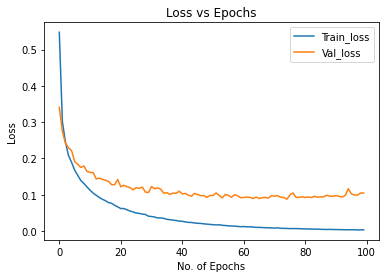

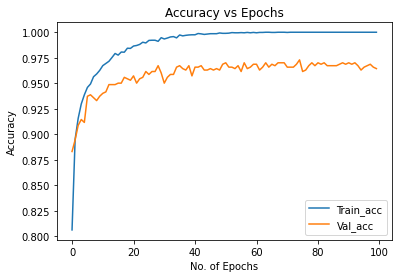

In [8]:
plt.plot(history.history['loss'],label='Train_loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


plt.plot(history.history['accuracy'],label = 'Train_acc')
plt.plot(history.history['val_accuracy'],label = 'Val_acc')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

In [9]:
test_data = ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_directory(test_path, target_size=(512,512), batch_size=32, shuffle=False, class_mode="categorical")

Found 705 images belonging to 4 classes.


In [10]:
predictions = np.argmax(model.predict(test_generator), axis=1)
matrix = confusion_matrix(test_generator.labels, predictions)
report= classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

In [11]:
pred = model.predict(test_generator,verbose=1)
test_generator_indices = np.argmax(pred,axis=1)

print(test_generator_indices)

23/23 [==============================] - 8s 334ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 3 1 1 1 1 0 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

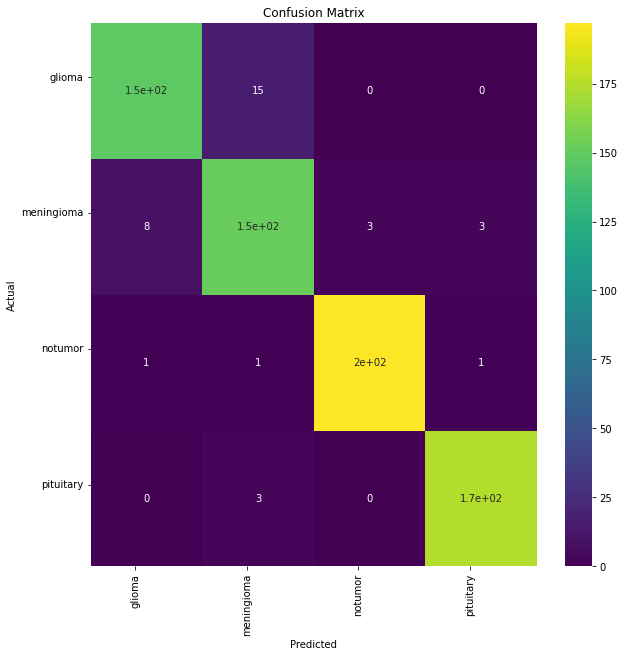

In [12]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.4, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.4, labels=test_generator.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [13]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.91      0.93       163
  meningioma       0.89      0.92      0.90       165
     notumor       0.98      0.98      0.98       200
   pituitary       0.98      0.98      0.98       177

    accuracy                           0.95       705
   macro avg       0.95      0.95      0.95       705
weighted avg       0.95      0.95      0.95       705



pip install numpy==1.23.4

pip install seaborn

In [14]:
!nvidia-smi

Sat Mar  9 14:36:25 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:3B:00.0 Off |                  Off |
| 69%   80C    P2    99W / 230W |  23610MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:AF:00.0 Off |                  Off |
| 44%   

import shutil

def zip_folder(folder_path, zip_filename):
    try:
        shutil.make_archive(zip_filename, 'zip', folder_path)
        print(f"Folder '{folder_path}' successfully zipped to '{zip_filename}.zip'")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
folder_to_zip = '/LAB/Brain Tumor/runs/clas/train8'
zip_file_name = '/LAB/Brain Tumor/Brain Tumor MRI/train8'

zip_folder(folder_to_zip, zip_file_name)
